# Chromosome 1 analysis

## Loading the data

Import the necessary packages:

In [1]:
import pandas as pd
import numpy as np
from trails.optimizer import trans_emiss_calc, post_prob_wrapper
from trails.read_data import maf_parser
from trails.cutpoints import cutpoints_ABC
%load_ext rpy2.ipython

n_int_AB_original = 3
n_int_ABC_original = 3

n_int_AB = 3
n_int_ABC = 3

Load the data:

In [2]:
# Read the output from TRAILS
df = pd.read_csv('../results/chr1_L-BFGS-B.csv')
# Find iteration with largest likelihood
df = df[df['loglik'] == df['loglik'].max()]
# Convert parameter estimates into dictionary
dct = dict(zip(list(df.columns), df.iloc[0].to_list()))

In [3]:
# Print dictionary
dct

{'n_eval': 252.0,
 't_A': 0.0029307448136187,
 't_B': 0.0030864038918802,
 't_C': 0.005659606389834,
 't_2': 0.0020879423249091,
 't_upper': 0.0049568487930341,
 'N_AB': 0.0034232595068766,
 'N_ABC': 0.002807779932867,
 'r': 0.9920256455623097,
 'loglik': -76112721.76133902,
 'time': 153659.25739312172}

The following lines can be used in case we would like to change from certain `n_int_AB` and `n_int_ABC` to another:

In [4]:
cut_ABC_original = (cutpoints_ABC(n_int_ABC_original, 1)*dct["N_ABC"])

In [5]:
t_ABC = cut_ABC_original[-2]+dct["t_upper"]
t_ABC

0.008041510331157506

In [6]:
cut_ABC = (cutpoints_ABC(n_int_ABC, 1)*dct["N_ABC"])
cut_ABC_last = cut_ABC[-2]
t_upper = t_ABC-cut_ABC_last
t_upper

0.0049568487930341

In [7]:
t_out = (((dct["t_A"]+dct["t_B"])/2+dct["t_2"])+dct["t_C"])/2 + cut_ABC_original[n_int_ABC_original-1]*dct["N_ABC"] + dct["t_upper"] + 2*dct["N_ABC"]

In [8]:
t_out

0.015959131243280803

## Parameter estimation

First, we can calculate the proportion of ILS from the estimated parameters. We can use the following function:

$\frac{2}{3}\exp\left(-\frac{t_2}{N_\text{AB}}\right)$

Since the units of $t_2$ are number of generations (multiplied by the mutation rate) and the units of $N_\text{AB}$ are number of individuals times two (multiplied by the mutation rate), then we can directly use the formula above:

In [13]:
(2/3)*np.exp(-(dct["t_2"])/(dct["N_AB"]))

0.36225994154321695

We can convert the raw units of the times into number of generations by dividing it by the mutation rate, and into years by then multiplying it by the generation time:

In [16]:
df_params = pd.DataFrame()
df_params['Names'] = ['H to HC', 'C to HC', 'HC to HCG', 'G to HCG', 'O (divergence)']
df_params['Raw values'] = [dct[i] for i in ['t_A', 't_B', 't_2', 't_C']] + [t_out]
df_params['Generations (mu = 1e-8)'] = df_params['Raw values']/1e-8
df_params['MY (mu = 1e-8, g = 20)'] = df_params['Raw values']/1e-8*20/1000000
df_params

,Names,Raw values,Generations (mu = 1e-8),"MY (mu = 1e-8, g = 20)"
0,H to HC,0.002931,2.930745e+05,5.861490
1,C to HC,0.003086,3.086404e+05,6.172808
2,HC to HCG,0.002088,2.087942e+05,4.175885
3,G to HCG,0.005660,5.659606e+05,11.319213
4,O (divergence),0.015959,1.595913e+06,31.918262


We can also convert the effective population sizes into diploid population size by dividing by 2 times the mutation rate:

In [11]:
df_params = pd.DataFrame()
df_params['Names'] = ['HC', 'HCG']
df_params['Raw values'] = [dct[i] for i in ['N_AB', 'N_ABC']]
df_params['N (mu = 1e-8)'] = df_params['Raw values']/1e-8/2
df_params

,Names,Raw values,N (mu = 1e-8)
0,Human-chimp,0.003423,171162.975344
1,Human-chimp-gorilla,0.002808,140388.996643


Finally, the recombination rate can be calculated by multiplying the raw value by the mutation rate:

In [18]:
df_params = pd.DataFrame()
df_params['Names'] = ['Recombination']
df_params['Raw value'] = [dct[i] for i in ['r']]
df_params['r (mu = 1e-8)'] = df_params['Raw value']*1e-8
df_params

,Names,Raw value,r (mu = 1e-8)
0,Recombination,0.992026,9.920256e-09


## Posterior decoding

Based on the estimated values, we can compute the transition and emission probabilities of the TRAILS model:

In [19]:
a, b, pi, hidden_names, observed_names = trans_emiss_calc(
    dct["t_A"], dct["t_B"], dct["t_C"], dct["t_2"], t_upper, t_out, 
    dct["N_AB"], dct["N_ABC"], dct["r"], n_int_AB, n_int_ABC)

2023-04-25 10:40:10,160	INFO worker.py:1518 -- Started a local Ray instance.


We can then parse the chr1 region using the TRAILS maf parser:

In [21]:
if 'obs' not in globals():
    obs = maf_parser('../data/chr1.filtered.region.maf', ['hg38','panTro5','gorGor5','ponAbe2'])

To calculate the posterior probabilities, we can use the `post_prob_wrapper` function:

In [22]:
post_prob = post_prob_wrapper(a, b, pi, obs)

In [23]:
len(post_prob)

2599

The following function is used to extract the sequence and position information from the maf alignment:

In [25]:
from Bio import AlignIO

def maf_seq(file, sp_lst):
    total_dct = {sp_lst[0]:[], sp_lst[1]:[], sp_lst[2]:[], sp_lst[3]:[]}
    start_dct = []
    # Start loglik accumulator
    loglik_acc = 0
    # For each block
    for multiple_alignment in AlignIO.parse(file, "maf"):
        # Save sequence
        dct = {}
        # For each sequence in the alignment block
        for seqrec in multiple_alignment:
            if seqrec.name.split('.')[0] in sp_lst:
                # Save nucleotides as ones and gaps as zeros
                dct[seqrec.name.split('.')[0]] = ''.join([str(int(j!='-')) for j in str(seqrec.seq)])
            if seqrec.name.split('.')[0] == 'hg38':
                # Save the start position of the block in human coordinates
                start = seqrec.annotations['start']
        # Append information to list
        if len(dct) == 4: 
            start_dct.append(start)
            for i in sp_lst:
                total_dct[i].append(dct[i])
    return total_dct, start_dct

# Get sequence and start information
seqinfo, startinfo = maf_seq('../data/chr1.filtered.region.maf', ['hg38','panTro5','gorGor5','ponAbe2'])

Now, we will iterate over the alignment blocks, save the position in human coordinates, and mark gaps as -9:

In [26]:
tot_lst = []
# For each block
for i in range(len(startinfo)):
    # Save start coordinate
    st = startinfo[i]
    tmp_lst = []
    # For each site in the human sequence
    for j in seqinfo['hg38'][i]:
        # If the site is not a gap
        if j == '1':
            # Append position
            tmp_lst.append(st)
            # Update coordinate
            st += 1
        # If it is a gap
        else:
            # Append -9
            tmp_lst.append(-9)
    tot_lst.append(tmp_lst)

In order to summarize the data, we will calculate the mean posterior probability in 100 kb windows for each of the hidden states:

In [27]:
# Create empty data frame
summary = pd.DataFrame()
# Define bin size
binsize = 100000
# For each block
for j in range(len(post_prob)):
    # Convert posteriors into data frame
    dat = pd.DataFrame(post_prob[j])
    # Add hidden states as column names
    dat.columns = [str(i) for i in list(hidden_names.values())]
    # Add position in human coordinates
    dat['position'] = tot_lst[j]
    # Filter gaps
    dat = dat[dat['position'] != -9]
    # Bin the result using the bin size
    dat['bin'] = dat['position'] // binsize
    # Calculate number of sites per bin
    t1 = dat.groupby('bin').agg(size=('(0, 0, 0)', 'size')).reset_index()
    # Calculate mean posterior probability per hidden state
    t2 = dat.groupby('bin').agg('mean').reset_index()
    # Append to overall result
    summary = pd.concat([summary, t1.merge(t2)])

In [28]:
summary

,bin,size,"(0, 0, 0)","(0, 0, 1)","(0, 0, 2)","(0, 1, 0)","(0, 1, 1)","(0, 1, 2)","(0, 2, 0)","(0, 2, 1)",...,"(2, 1, 1)","(2, 1, 2)","(2, 2, 2)","(3, 0, 0)","(3, 0, 1)","(3, 0, 2)","(3, 1, 1)","(3, 1, 2)","(3, 2, 2)",position
0,249,1485,0.059376,0.045361,0.032477,0.063253,0.048308,0.034891,0.065539,0.049912,...,0.005835,0.031619,0.000807,0.016457,0.041227,0.029339,0.005012,0.012239,0.000635,24999257.0
1,250,1929,0.098284,0.097102,0.059970,0.083475,0.087555,0.056001,0.060627,0.069071,...,0.004343,0.010720,0.000351,0.013085,0.042610,0.030936,0.005438,0.012773,0.000696,25000964.0
0,250,33301,0.049442,0.051526,0.043506,0.053750,0.057129,0.050820,0.057606,0.061617,...,0.007759,0.021317,0.001107,0.017555,0.066927,0.062076,0.007660,0.025046,0.001229,25019223.0
0,250,5663,0.025127,0.025917,0.033935,0.030188,0.031515,0.043258,0.038004,0.038210,...,0.009360,0.051860,0.004073,0.018310,0.096114,0.112221,0.011734,0.051486,0.004018,25039137.0
0,250,15299,0.041599,0.034018,0.030873,0.051315,0.041448,0.036887,0.064017,0.050964,...,0.009093,0.031347,0.001799,0.023112,0.073953,0.076108,0.008858,0.031166,0.001976,25050536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,749,16354,0.065712,0.069160,0.059964,0.074016,0.081219,0.071801,0.070156,0.084405,...,0.005183,0.012038,0.000703,0.012176,0.035065,0.020883,0.004785,0.010090,0.000650,74908176.5
0,749,22742,0.083584,0.076218,0.061302,0.074402,0.070884,0.059135,0.065005,0.064654,...,0.005524,0.019271,0.000896,0.014670,0.041209,0.027956,0.005113,0.012133,0.000729,74939848.5
0,749,35588,0.062584,0.044627,0.029602,0.070994,0.048981,0.031957,0.082253,0.055461,...,0.007726,0.019360,0.000818,0.028315,0.081938,0.053732,0.007602,0.017547,0.000740,74970405.5
0,749,8078,0.105355,0.109783,0.092215,0.082241,0.087583,0.074204,0.059913,0.066003,...,0.002867,0.005579,0.000252,0.011391,0.033805,0.020111,0.003011,0.006456,0.000254,74995960.5


We can import the data frame into R for plotting:

In [29]:
%%R -i summary -i binsize

library(tidyverse)

totab <- summary %>%
    # Convert to tibble
    as_tibble() %>%
    # Remove unused columns
    select(-position) %>%
    # Pivot table
    pivot_longer(-c(bin, size)) %>%
    # For each bin and hidden state
    group_by(bin, name) %>%
    summarize(
        # Calculate the mean posterior weighted by 
        # the number of sites
        value = weighted.mean(value, size),
        size = sum(size)
    ) %>%
    # Convert hidden state names into plottable info
    mutate(
        name = str_remove_all(name, '\\('),
        name = str_remove_all(name, '\\)')
    ) %>%
    separate(name, c('V', 't1', 't2'), ', ') %>%
    mutate(
        V = as.integer(V),
        t1 = as.integer(t1),
        t2 = as.integer(t2),
        is_V0 = V == 0
    ) 
totab 

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.
# A tibble: 13,554 × 7
# Groups:   bin [502]
     bin     V    t1    t2  value  size is_V0
   <int> <int> <int> <int>  <dbl> <int> <lgl>
 1   249     0     0     0 0.0594  1485 TRUE 
 2   249     0     0     1 0.0454  1485 TRUE 
 3   249     0     0     2 0.0325  1485 TRUE 
 4   249     0     1     0 0.0633  1485 TRUE 
 5   249     0     1     1 0.0483  1485 TRUE 
 6   249     0     1     2 0.0349  1485 TRUE 
 7   249     0     2     0 0.0655  1485 TRUE 
 8   249     0     2     1 0.0499  1485 TRUE 
 9   249     0     2     2 0.0367  1485 TRUE 
10   249     1     0     0 0.0179  1485 FALSE
# … with 13,544 more rows


In [30]:
%%R -w 2000 -h 150 -r 150

# Load packages
library(ggHoriPlot)
library(ggthemes)

p_ILS <- totab %>%
    # Group by bin and topology
    group_by(bin, V) %>%
    # Sum the mean posterior
    summarize(
        value = sum(value)
    ) %>%
    # Group only by bin
    group_by(bin) %>%
    # Calculate ILS proxy from the mean posterior
    summarize(
        ILS = sum(value[V %in% c(2, 3)])/sum(value)
    ) %>%
    # Convert bins into coordinates
    mutate(bin = bin*binsize/1000000) %>%
    # Plot as horizon plot
    ggplot() +
    geom_horizon(aes(x = bin, xend = bin+(binsize-1)/1000000, y = ILS,
                     fill=..Cutpoints..), horizonscale = 4, rm.outliers = T) +
    theme_few() +
    scale_fill_hcl(palette = 'PuOr', labels = c('High', '', '', 'Low'), name = 'ILS') +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_x_continuous(expand = c(0, 0))

`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.


In [31]:
%%R -w 2000 -h 300 -r 150

# This is similar to the previous block, 
# but for the second coalescent
p_t2 <- totab %>%
    group_by(bin, t2) %>%
    summarize(
        value = sum(value)
    ) %>%
    group_by(bin) %>%
    summarize(value = weighted.mean(t2, value)) %>%
    mutate(bin = bin*binsize/1000000) %>%
    ggplot() +
    geom_horizon(aes(x = bin, xend = bin+(binsize-1)/1000000, y = value, fill=..Cutpoints..), 
                 horizonscale = 4, rm.outliers = T) +
    theme_few() +
    scale_fill_hcl(
        palette = 'PuOr', 
        labels = c('Deep', '', '', 'Young'), 
        name = 'Second\ncoalescent'
    ) +
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_x_continuous(expand = c(0, 0))

`summarise()` has grouped output by 'bin'. You can override using the `.groups` argument.


In [32]:
%%R -w 2000 -h 300 -r 150 -i n_int_AB

# This is similar to the previous block, 
# but for the first coalescent
p_t1 <- totab %>%
    group_by(bin, t1, is_V0) %>%
    summarize(
        value = sum(value)
    ) %>%
    ungroup() %>%
    mutate(
        t1 = ifelse(!is_V0, t1+n_int_AB, t1)
    ) %>%
    group_by(bin) %>%
    summarize(value = weighted.mean(t1, value)) %>%
    mutate(bin = bin*binsize/1000000) %>%
    ggplot() +
    geom_horizon(aes(x = bin, xend = bin+(binsize-1)/1000000, y = value, fill=..Cutpoints..), 
                 horizonscale = 4, rm.outliers = T) +
    theme_few() +
    scale_fill_hcl(palette = 'PuOr', labels = c('Deep', '', '', 'Young'), name = 'First\ncoalescent') +
    theme(
        axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()
    ) +
    scale_y_continuous(expand = c(0, 0)) +
    scale_x_continuous(expand = c(0, 0)) +
    xlab('Position along human chr1 (Mb)')

`summarise()` has grouped output by 'bin', 't1'. You can override using the `.groups` argument.


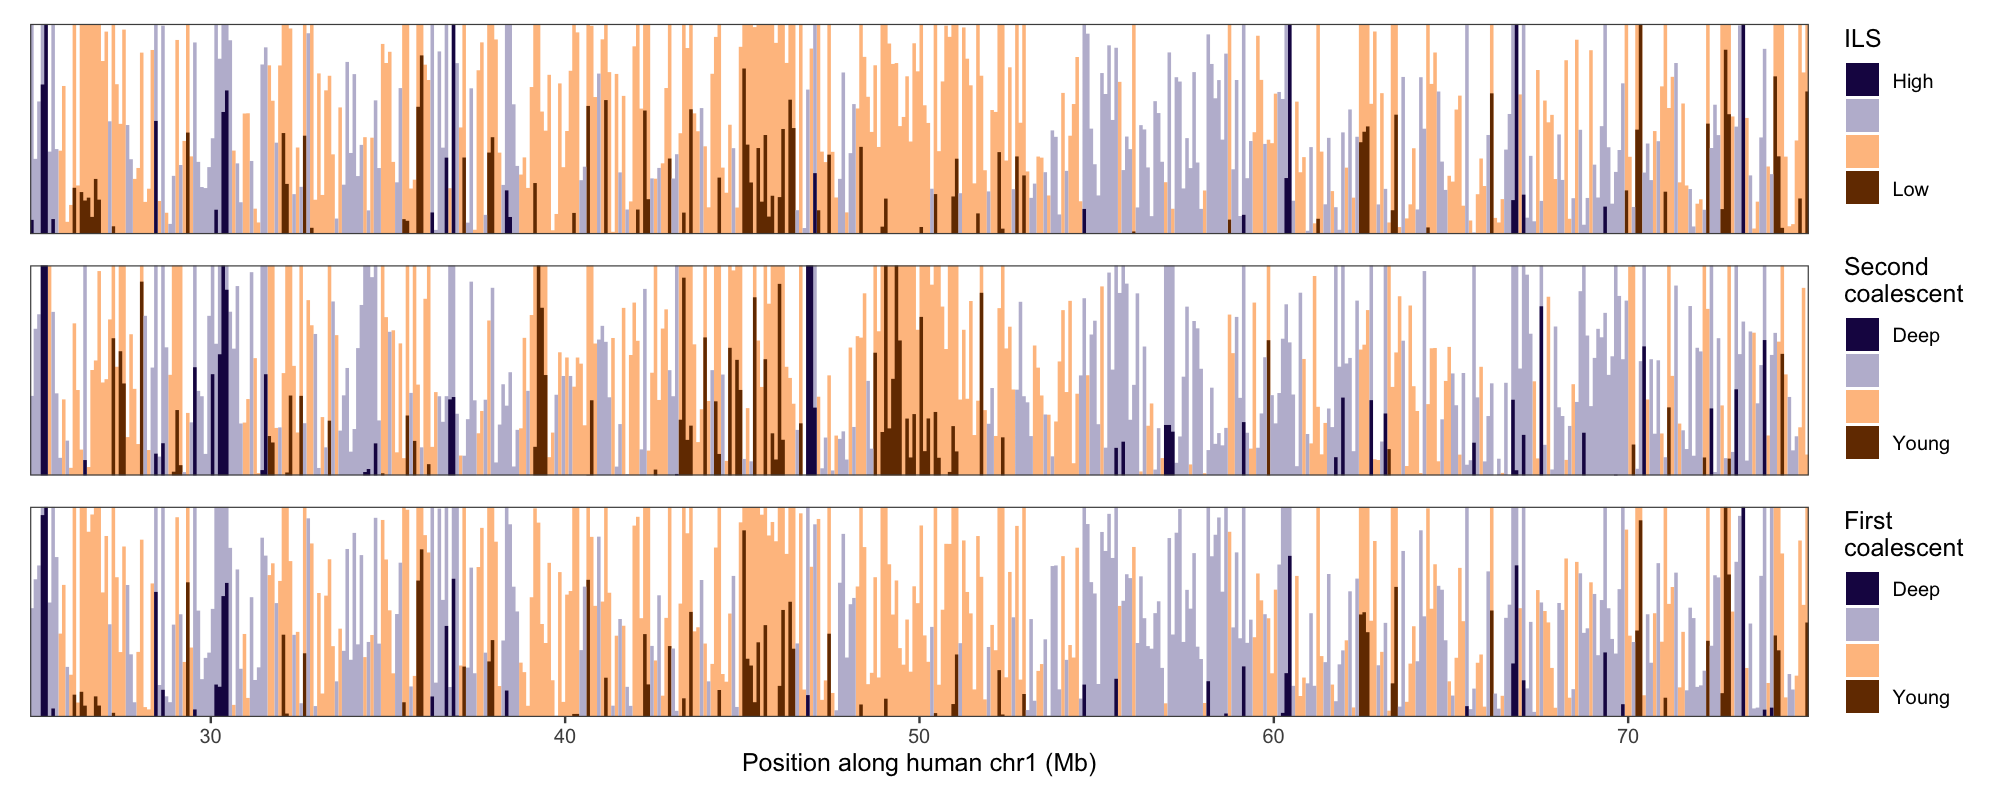

In [34]:
%%R -w 2000 -h 800 -r 150

library(patchwork)

p_ILS / p_t2 / p_t1 + plot_layout(guides = 'collect')